In [354]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

rng = np.random.RandomState(42)

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster


<h1>Population Dataset <br></h1>
Sheet1 => content page <br>
Sheet2 => Singapore Residents By Age Group, Ethnic Group And Sex, End June, Annual <br>
Sheet3 => Singapore Citizens By Age Group, Ethnic Group And Sex, End June, Annual <br>
Sheet4 => Singapore Residents By Single Year Of Age And Sex, At End June, Annual <br>
Sheet5 => Residents By Age Group & Type Of Dwelling, Annual <br>
Sheet6 => Indicators On Population, Annual <br>



<h1>Data required for this project:</h1>
<ul>
<li>Property Price Distribution (Given)</li>
<li>Singapore Residents By Age Group, Ethnic Group And Sex, End June, Annual (Self Sourced)</li>
<li>Residents By Age Group & Type Of Dwelling, Annual (Self Sourced)</li>
<li>Indicators On Population, Annual (Self Sourced)</li>
</ul>

In [2]:
# population indicator df
# import data and transpose
population = pd.read_csv("./population_indicators.csv").transpose()
# select data up to the year 2000
population = population.loc[:'2000']
# Rename first row as columns
population = population.rename(columns = population.iloc[0]).drop(population.index[0])
# population = population.drop(population.columns[6:],axis=1)
population = population.applymap(lambda x: int(x.replace(',', '')) if not '.' in x else float(x))
# drop all column names with Ratio since they are collinear with the population data
population = population[[x for x in list(
    population.columns) if 'ratio' not in x.lower() ]]
population.head()


,Total Population (Number),Resident Population (Number),Singapore Citizen Population (Number),Permanent Resident Population (Number),Non-Resident Population (Number),Total Population Growth (Per Cent),Resident Population Growth (Per Cent),Population Density (Total Population Per Square Kilometre),Median Age Of Resident Population (Years),Median Age Of Citizen Population (Years),Natural Increase (Number),Rate Of Natural Increase (Per Thousand Residents)
2021,5453566,3986842,3498191,488651,1466724,-4.1,-1.4,7485,41.8,42.5,14431,2.7
2020,5685807,4044210,3523191,521019,1641597,-0.3,0.4,7810,41.5,42.2,16536,3.3
2019,5703569,4026209,3500940,525269,1677360,1.2,0.8,7866,41.1,42.0,17833,3.7
2018,5638676,3994283,3471936,522347,1644393,0.5,0.7,7804,40.8,41.7,17757,3.7
2017,5612253,3965796,3439177,526619,1646457,0.1,0.8,7796,40.5,41.3,18710,4.0


In [3]:
# dewlling df
# import data and transpose
dwellings = pd.read_csv("./dwellings.csv").transpose()
# make first row as columns
dwellings = dwellings.rename(
    columns=dwellings.iloc[0]).drop(dwellings.index[0])
# map values to int
dwellings = dwellings.applymap(lambda x: int(x.replace(',','')))
dwellings = dwellings.drop(['Residents'],axis=1)
dwellings.head()
# lets group the dewlling infomation by age groups


,Total HDB Dwellings,HDB 1- And 2-Room Flats,HDB 3-Room Flats,HDB 4-Room Flats,HDB 5-Room And Executive Flats,Condominiums & Other Apartments,Landed Properties,Other Types Of Dwelling,0-4 Years,Total HDB Dwellings,...,Other Types Of Dwelling,90 Years & Over,Total HDB Dwellings,HDB 1- And 2-Room Flats,HDB 3-Room Flats,HDB 4-Room Flats,HDB 5-Room And Executive Flats,Condominiums & Other Apartments,Landed Properties,Other Types Of Dwelling
2021,3090959,179559,557100,1312346,1041954,620246,240841,34796,178435,138502,...,2370,22090,15440,1736,4147,5632,3925,1363,2613,2674
2020,3152410,177358,575200,1338374,1061478,607937,248860,35003,183076,144145,...,2310,20875,14636,1655,3890,5346,3745,1255,2453,2531
2019,3154524,173771,580233,1337743,1062777,587860,249077,34748,185355,146195,...,2080,19429,13540,1569,3570,4898,3503,1187,2271,2431
2018,3149249,170955,584821,1331440,1062033,562228,248240,34566,185528,147012,...,2019,17786,12414,1449,3262,4463,3240,1094,2080,2198
2017,3156575,168052,590806,1330160,1067557,525584,249408,34229,187653,150516,...,1910,16454,11462,1345,3041,4140,2936,1037,1916,2039


In [4]:
# save the column index range for children, adult and elderly data
dwellingsAgeGroupColumns = list(dwellings.columns)[8:]
dwellingAgeGroupArr = {'Children': [],
                       'Adult': [], 'Elderly': []}
for i in range(len(list(dwellings.columns))//9):
    a = dwellingsAgeGroupColumns[i*9:i*9+9]
    if '-' in a[0][:2] or a[0][:2] < '15':
        dwellingAgeGroupArr['Children'].append([8+i*9,8+i*9+9])
    elif a[0][:2] < '65':
        dwellingAgeGroupArr['Adult'].append([8+i*9, 8+i*9+9])
    else:
        dwellingAgeGroupArr['Elderly'].append([8+i*9,8+i*9+9])


In [5]:
premadeColumnNames = ['_Dwellers', '_Total HDB Dwellings', '_HDB 1 And 2 Room Flats',   '_HDB 3-Room Flats',	  '_HDB 4-Room Flats',
                      '_HDB 5-Room And Executive Flats',   '_Condominiums & Other Apartments',   '_Landed Properties',   '_Other Types Of Dwelling']


def sumColumns(group):
    dummy = pd.DataFrame({})
    for rg in dwellingAgeGroupArr[group]:
        df = dwellings.iloc[:, rg[0]:rg[1]].copy()
        df.columns = premadeColumnNames
        if dummy.empty:
            dummy = df
        else:
            dummy += df
        # print(dwellings.iloc[:,rg[0]:rg[1]])
    dummy.columns = [f'{group}{x}' for x in list(dummy.columns)]
    return dummy
    
# sum these data together and form 1 dataFrame
dwellingsByAgeGroup = pd.concat(
    [sumColumns('Children'), sumColumns('Adult'), sumColumns('Elderly')], axis=1)
dwellingsByAgeGroup.head()

,Children_Dwellers,Children_Total HDB Dwellings,Children_HDB 1 And 2 Room Flats,Children_HDB 3-Room Flats,Children_HDB 4-Room Flats,Children_HDB 5-Room And Executive Flats,Children_Condominiums & Other Apartments,Children_Landed Properties,Children_Other Types Of Dwelling,Adult_Dwellers,...,Adult_Other Types Of Dwelling,Elderly_Dwellers,Elderly_Total HDB Dwellings,Elderly_HDB 1 And 2 Room Flats,Elderly_HDB 3-Room Flats,Elderly_HDB 4-Room Flats,Elderly_HDB 5-Room And Executive Flats,Elderly_Condominiums & Other Apartments,Elderly_Landed Properties,Elderly_Other Types Of Dwelling
2021,577188,425749,22955,55975,191418,155401,118271,31296,1872,2770646,...,16516,639008,516327,49856,127231,196767,142473,53813,52460,16408
2020,588206,440318,22918,60629,197746,159025,114460,31325,2103,2841636,...,17076,614368,495212,47395,123935,188040,135842,51756,51576,15824
2019,591056,445622,22900,63091,198448,161183,111735,31538,2161,2853473,...,17436,581680,468794,44547,119547,177189,127511,48242,49493,15151
2018,591124,450566,23322,64978,197989,164277,106746,31471,2341,2855305,...,17779,547854,441018,41773,114477,166071,118697,45113,47277,14446
2017,594481,461039,23779,67293,199711,170256,99011,31918,2513,2854623,...,18448,516692,416206,38987,109977,156073,111169,41694,45524,13268


In [6]:
# import data from csv
residents = pd.read_csv(
    "./singapore_residents_by_age_group_ethnicity_sex.csv")
# slice the df to only contain residents count from 2021 - 2000
residents = residents.loc[:18,:'2000']
# transpose
residents = residents.transpose()
# first row as column
residents = residents.rename(
    columns=residents.iloc[0]).drop(residents.index[0])



<p>
It is common in demography to split the population into three broad age groups:
<ul>
<li>children and young adolescents (under 15 years old)
<li>the working-age population (15-64 years) and.
<li>the elderly population (65 years and older)
</ul>
</p>
Source: <a>https://ourworldindata.org/age-structure</a>


In [7]:
# group residents by age
# make group by column names
ageGroup = {'Children Residents': [], 'Adult Residents': [], 'Elderly Residents': []}
for col in residents.columns[1:].to_list():
    age = int(col.strip()[:2].strip())
    if age < 15:
        ageGroup['Children Residents'].append(residents.columns.to_list().index(col))
    elif age < 65:
        ageGroup['Adult Residents'].append(residents.columns.to_list().index(col))
    else:
        ageGroup['Elderly Residents'].append(residents.columns.to_list().index(col))

def makeAgeGroup(columns):
    # return sum([int(x.replace(',', '')) for x in columns[ageGroup['children']].to_list()])
    return [sum([int(x.replace(',', '')) for x in columns[ageGroup[key]].to_list()]) for key in ageGroup.keys()]

# apply makeAgeGroup function and split into 3 columns
ageGroupdf = pd.DataFrame(residents.apply(lambda x: makeAgeGroup(x), axis=1).to_list(), columns=list(ageGroup.keys()))
ageGroupdf.index = residents.index
residents = pd.concat([residents, ageGroupdf],axis=1)
# drop unnecessary columns
residents = residents.drop(residents.columns[list(
    itertools.chain(*list(ageGroup.values())))], axis=1)
# map Total Residents to int
residentsByAgeGroup = residents.drop(['Total Residents'], axis=1)
residentsByAgeGroup.head()


,Children Residents,Adult Residents,Elderly Residents
2021,577188,2770646,616918
2020,588206,2841636,593493
2019,591056,2853473,562251
2018,591124,2855305,530068
2017,594481,2854623,500238


In [54]:
populationDf = pd.concat(
    [population, residentsByAgeGroup, dwellingsByAgeGroup], axis=1)
populationDf.index = populationDf.index.astype('int64')
print(
    f'Number of rows with missing values: {populationDf.isnull().any(axis=1).mean()}')
populationFeatures = list(populationDf.columns)
populationFeatures = [
    x for x in populationFeatures if 'Residents' not in x and '_Dwellers' not in x]
populationFeatures = [
    x for x in populationFeatures if 'Residents' not in x and '_Dwellers' not in x]
populationDf = populationDf[populationFeatures]


Number of rows with missing values: 0.0


In [35]:
resale_data = pd.read_csv('./train.csv')

In [36]:
# since we are looking at the trend of property price, independent variables are sold year, flat type, dependent variable is resale price/sqm
resale_data.head()

,town,lat,lng,month,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,GEYLANG,NaN,NaN,2006-01-01,4 ROOM,328,UBI AVE 1,04 TO 06,84.0,Simplified,1985.0,175000.0,NaN
1,JURONG EAST,NaN,NaN,2003-02-01,5 ROOM,271,TOH GUAN RD,10 TO 12,120.0,Improved,1999.0,353000.0,NaN
2,TOA PAYOH,NaN,NaN,2005-09-01,3 ROOM,205,TOA PAYOH NTH,10 TO 12,65.0,Improved,1973.0,215000.0,NaN
3,PASIR RIS,NaN,NaN,2001-03-01,EXECUTIVE,508,PASIR RIS ST 52,04 TO 06,146.0,Apartment,1993.0,482000.0,NaN
4,JURONG WEST,NaN,NaN,2014-07-01,EXECUTIVE,656B,JURONG WEST ST 61,10 TO 12,133.0,Apartment,2001.0,613000.0,NaN


In [159]:
# def classifyModel(model):
#     if 'Maisonette' in model or 'Generation' in model:
#         return 'Maisonette'
#     elif 'Type' in model:
#         return 'Type'
#     elif 'Model' in model:
#         return 'Model'
#     elif 'Apartment' in model:
#         return 'Apartment'
#     else:
#         return model

resaledf = resale_data[['flat_type', 'month',
                            'floor_area_sqm', 'resale_price']].copy()
resaledf['month'] = pd.to_datetime(resaledf['month'])
resaledf['year_sold'] = resaledf['month'].dt.strftime(
    '%Y').astype('int64')
resaledf['price_per_sqm'] = resaledf['resale_price'] / \
    resaledf['floor_area_sqm']
resaledf = resaledf[resaledf['year_sold'] <=2021]
resaledf.drop(['month', 'floor_area_sqm',
                  'resale_price'], axis=1, inplace=True)
resaledf = resaledf.groupby(['year_sold', 'flat_type']).mean()
resaledf=resaledf.reset_index(level=[0,1])
resaledf=resaledf.pivot('year_sold','flat_type','price_per_sqm')
resaledf.index.name = 'year'


In [161]:
resaledf.tail()

flat_type,1 ROOM,2 ROOM,3 ROOM,4 ROOM,5 ROOM,EXECUTIVE,MULTI-GENERATION
year,,,,,,,
2017,6451.612903,5305.176390,4663.605988,4597.880033,4515.281672,4345.293777,4633.648474
2018,5955.645161,5191.575080,4489.682402,4547.854825,4496.140893,4368.649129,4990.765586
2019,5646.121864,4975.987474,4403.845822,4541.559182,4463.029835,4261.466360,4978.977304
2020,5766.129032,5061.122570,4600.731557,4762.983781,4637.009580,4379.491499,4844.669788
2021,6362.007168,5805.785281,5181.415324,5377.000976,5162.393626,4875.930048,5301.695349


Text(0.5, 1.0, 'Resale Property Price trend from 2000 to 2020')

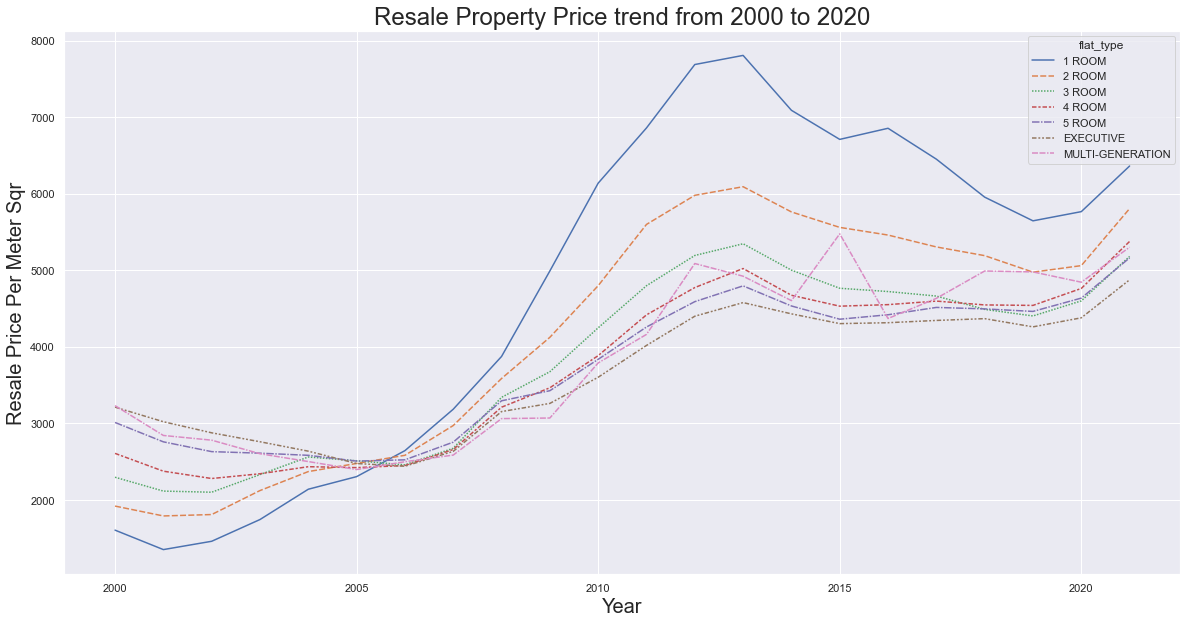

In [162]:
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf)
p.set_ylabel('Resale Price Per Meter Sqr',fontsize=20)
p.set_xlabel('Year',fontsize=20)
p.set_title('Resale Property Price trend from 2000 to 2020', fontsize=24)

In [40]:
flat_model = {}
for flat_type in resale_data.flat_type.unique():
    flat_model[flat_type] = list(resale_data[resale_data['flat_type'] == flat_type]['flat_model'].unique())

for k,v in flat_model.items():
    print(k,v)

4 ROOM ['Simplified', 'Improved', 'Model A2', 'Model A', 'New Generation', 'Premium Apartment', 'Standard', 'Adjoined flat', 'DBSS', 'Type S1', 'Premium Apartment Loft', 'Terrace']
5 ROOM ['Improved', 'DBSS', 'Standard', 'Model A', 'Premium Apartment', 'Adjoined flat', 'Model A-Maisonette', 'Type S2', 'Improved-Maisonette', 'Premium Apartment Loft']
3 ROOM ['Improved', 'Model A', 'New Generation', 'Simplified', 'Terrace', 'Standard', 'Premium Apartment', 'DBSS', 'Adjoined flat']
EXECUTIVE ['Apartment', 'Maisonette', 'Adjoined flat', 'Premium Apartment', 'Premium Maisonette']
2 ROOM ['Standard', 'Improved', 'Model A', 'Premium Apartment', '2-room', 'DBSS']
1 ROOM ['Improved']
MULTI-GENERATION ['Multi Generation']


In [155]:
# join population dataset with resale df
joinDf = resaledf.join(populationDf,how='inner')
# convert index to timeseries
joinDf.index = pd.to_datetime(joinDf.index, format='%Y')

# add freq to datetime
joinDf=joinDf.asfreq('MS')
joinDf=joinDf.interpolate()
joinDf = joinDf.applymap(lambda x:int(x))


In [163]:
populationDf = joinDf[populationDf.columns.to_list()]
resaledf = joinDf[resaledf.columns.to_list()]


In [165]:
populationDf.head()

,Total Population (Number),Resident Population (Number),Singapore Citizen Population (Number),Permanent Resident Population (Number),Non-Resident Population (Number),Total Population Growth (Per Cent),Resident Population Growth (Per Cent),Population Density (Total Population Per Square Kilometre),Median Age Of Resident Population (Years),Median Age Of Citizen Population (Years),...,Adult_Landed Properties,Adult_Other Types Of Dwelling,Elderly_Total HDB Dwellings,Elderly_HDB 1 And 2 Room Flats,Elderly_HDB 3-Room Flats,Elderly_HDB 4-Room Flats,Elderly_HDB 5-Room And Executive Flats,Elderly_Condominiums & Other Apartments,Elderly_Landed Properties,Elderly_Other Types Of Dwelling
2000-01-01,4027887,3273363,2985886,287477,754524,1,1,5900,34,34,...,169626,24115,193663,21100,62877,67697,40784,10354,24095,7184
2000-02-01,4037064,3277741,2988486,289254,759322,1,1,5913,34,34,...,169670,24001,194210,21098,62984,67937,40986,10446,24155,7178
2000-03-01,4046241,3282119,2991087,291032,764121,1,1,5927,34,34,...,169714,23887,194758,21096,63092,68177,41189,10539,24216,7172
2000-04-01,4055418,3286497,2993687,292810,768920,1,1,5941,34,34,...,169758,23773,195306,21094,63199,68418,41392,10632,24276,7166
2000-05-01,4064595,3290876,2996288,294588,773719,2,1,5955,34,34,...,169802,23659,195853,21092,63307,68658,41595,10725,24337,7161


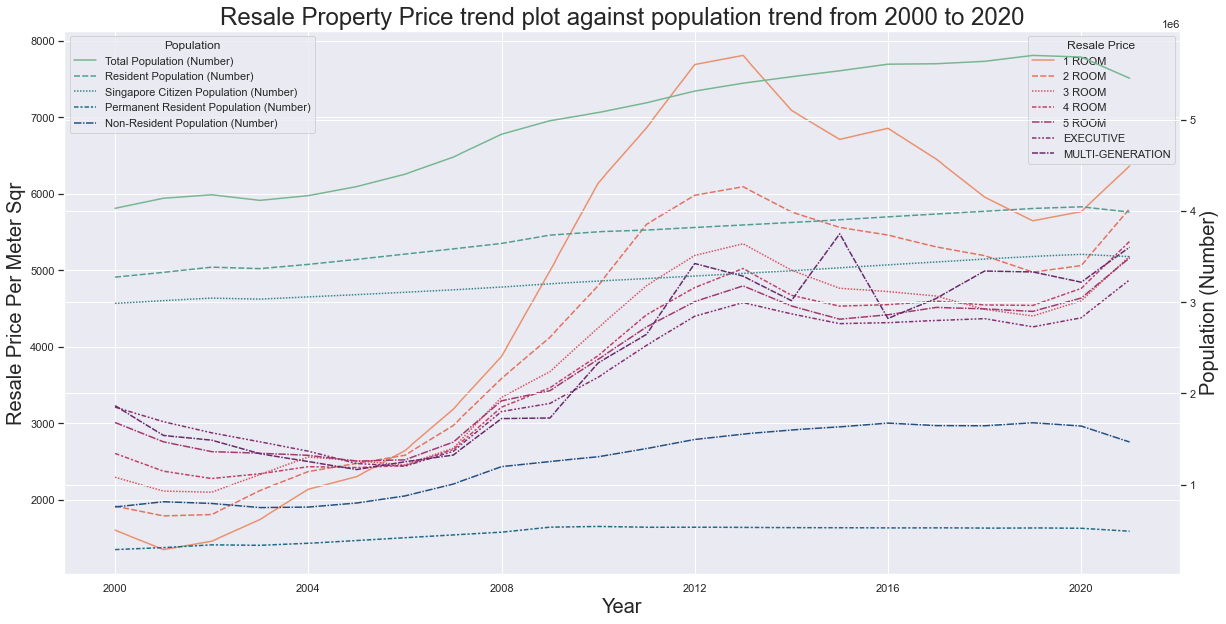

In [166]:
# plot resale price vs population size
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title('Resale Property Price trend plot against population trend from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf.iloc[:,:5], ax=ax2, palette='crest')
q.set_ylabel('Population (Number)',fontsize=20)
q.legend(loc='upper left', title="Population")


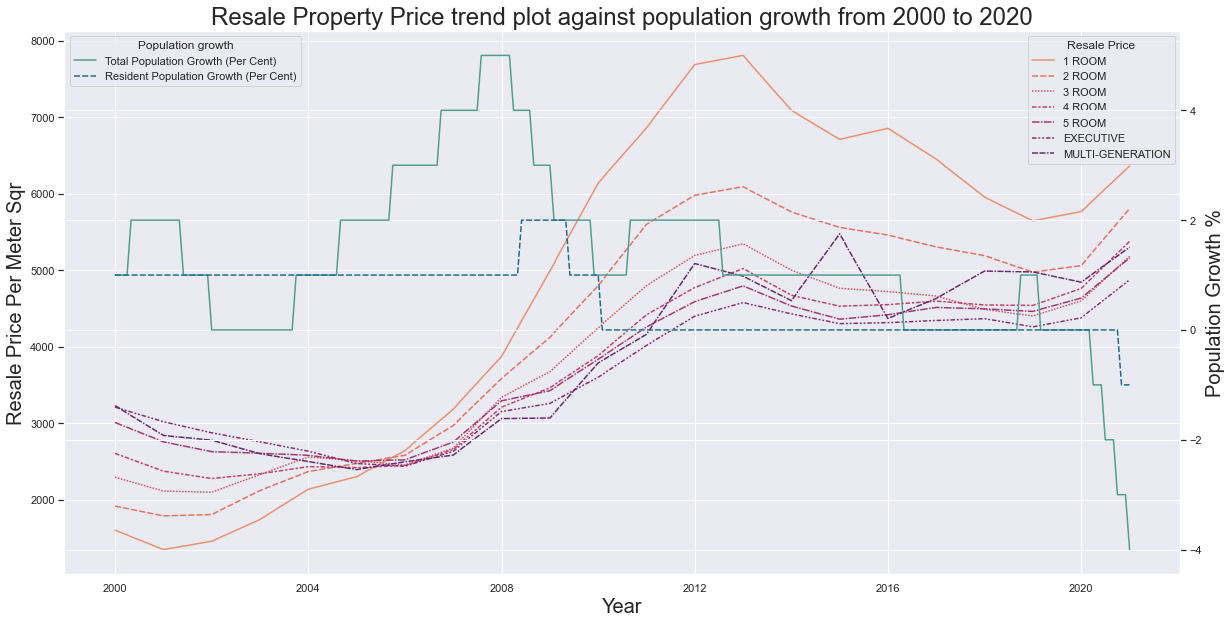

In [167]:
# plot resale price vs population growth
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against population growth from 2000 to 2020', fontsize=24)
p.legend(loc='upper right',title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf.iloc[:, 5:7], ax=ax2, palette='crest')
q.set_ylabel('Population Growth %', fontsize=20)
q.legend(loc='upper left', title="Population growth")


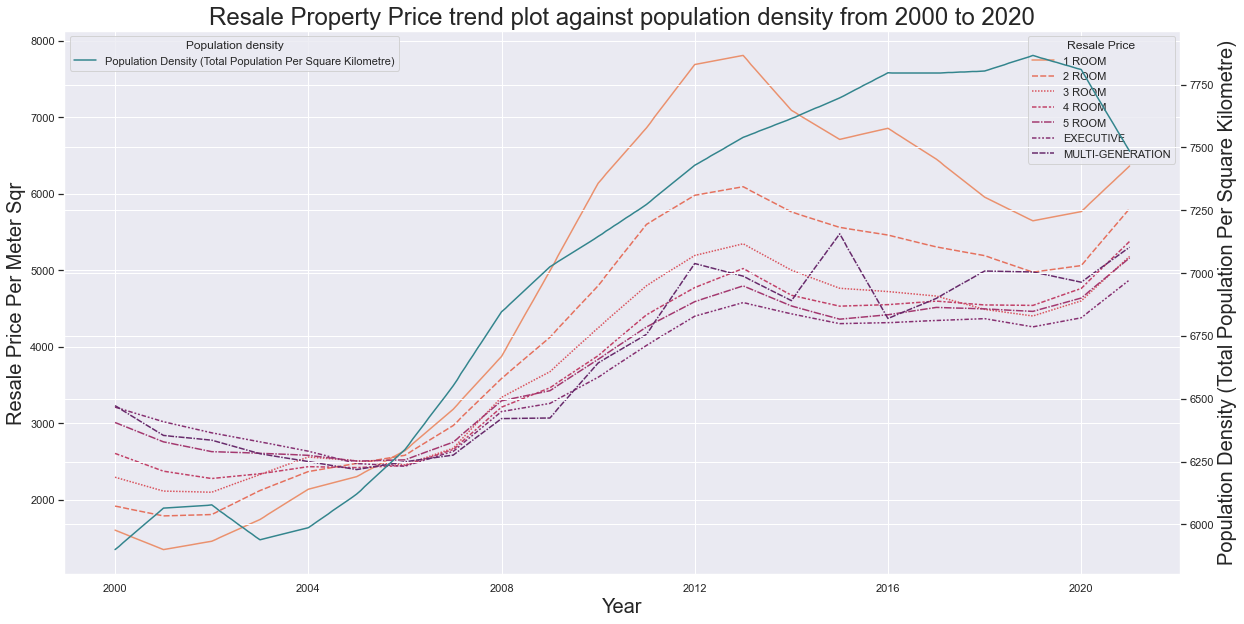

In [168]:
# plot resale price vs population density
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against population density from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf.iloc[:, 7:8], ax=ax2, palette='crest')
q.set_ylabel(
    'Population Density (Total Population Per Square Kilometre)', fontsize=20)
q.legend(loc='upper left', title="Population density")


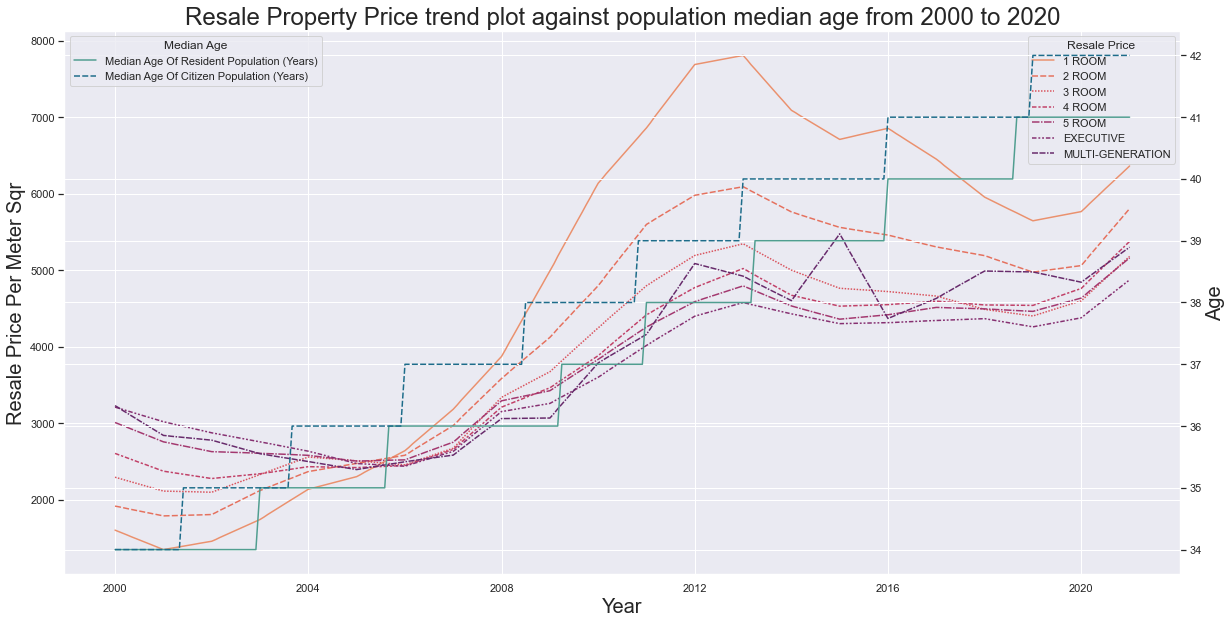

In [169]:
# plot resale price vs age
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against population median age from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf.iloc[:, 8:10], ax=ax2, palette='crest')
q.set_ylabel('Age', fontsize=20)
q.legend(loc='upper left', title="Median Age")


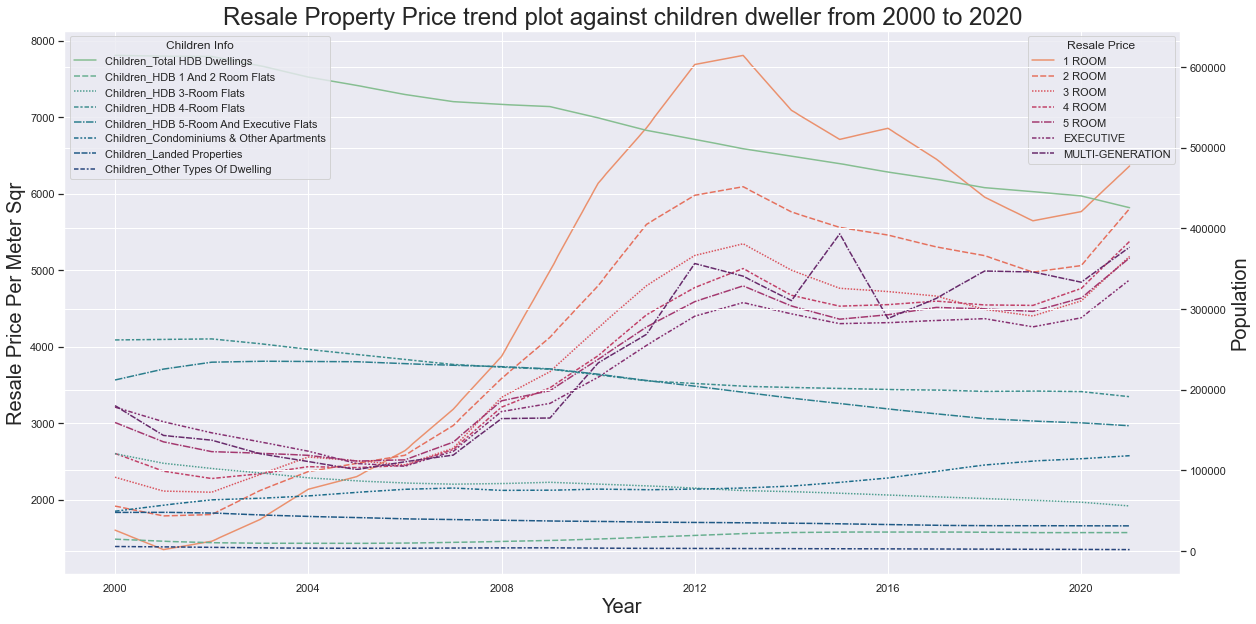

In [170]:
# plot resale price vs children population and dweller info
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against children dweller from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf[[x for x in list(
    populationDf.columns) if 'Children' in x]], ax=ax2, palette='crest')
q.set_ylabel('Population', fontsize=20)
q.legend(loc='upper left', title="Children Info")


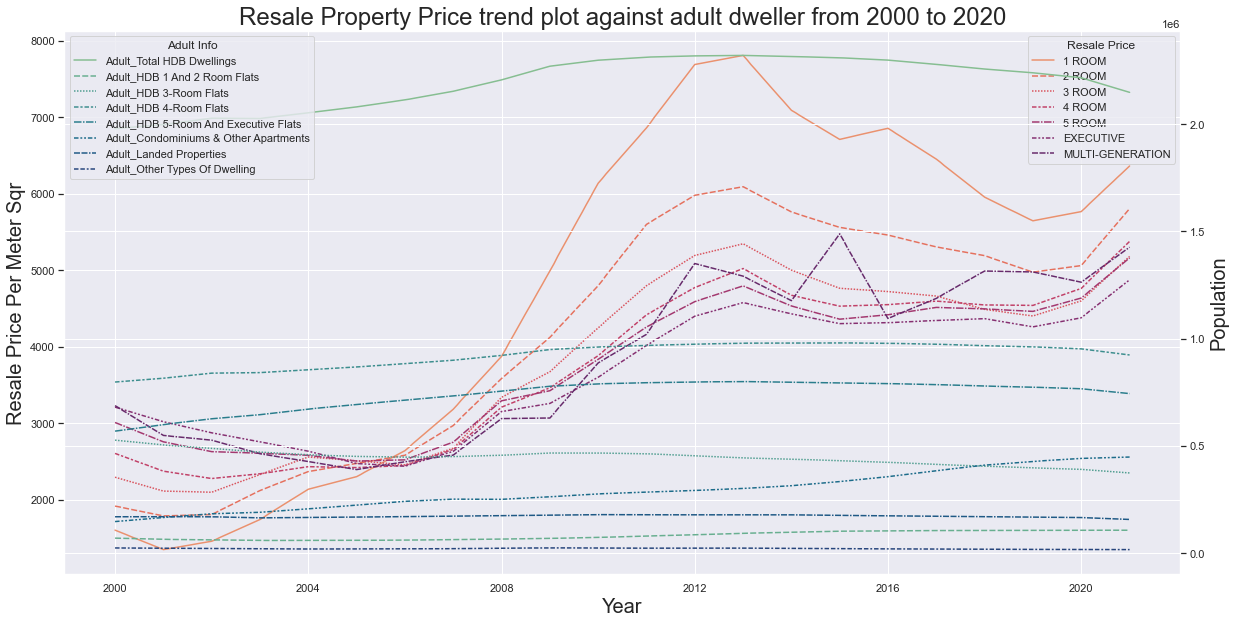

In [171]:
# plot resale price vs adult population and dweller info
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against adult dweller from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf[[x for x in list(
    populationDf.columns) if 'Adult' in x]], ax=ax2, palette='crest')
q.set_ylabel('Population', fontsize=20)
q.legend(loc='upper left', title="Adult Info")


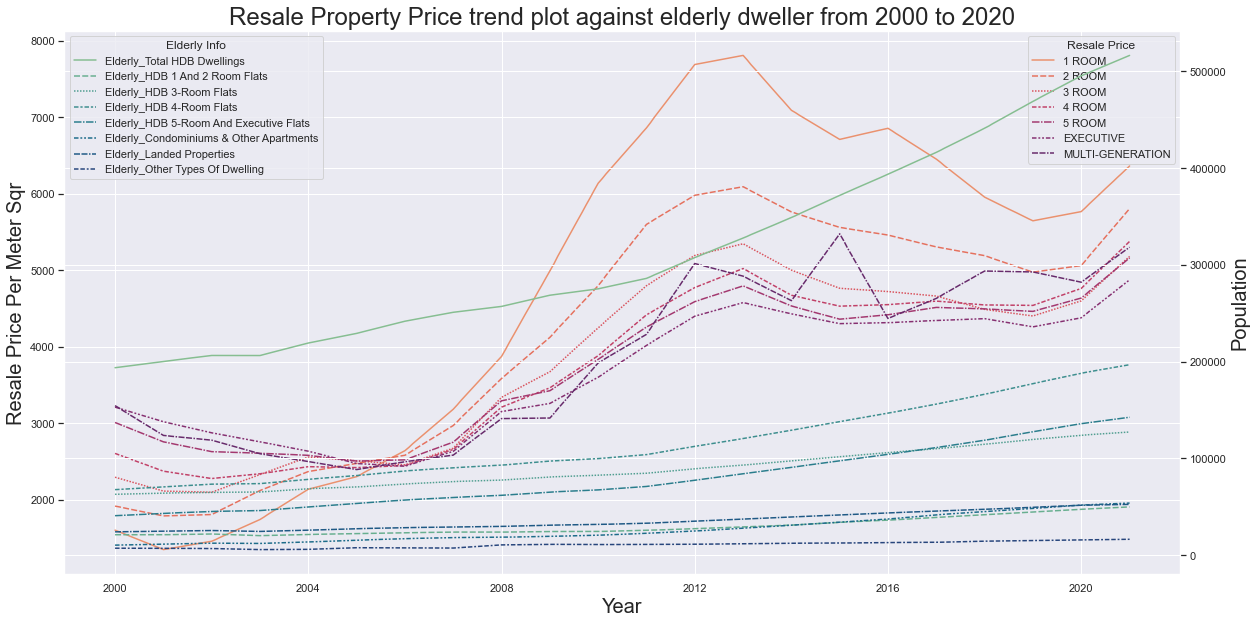

In [172]:
# plot resale price vs elderly population and dweller info
sns.set(rc={'figure.figsize': (20, 10)})
p = sns.lineplot(data=resaledf, palette='flare')
p.set_ylabel('Resale Price Per Meter Sqr', fontsize=20)
p.set_xlabel('Year', fontsize=20)
p.set_title(
    'Resale Property Price trend plot against elderly dweller from 2000 to 2020', fontsize=24)
p.legend(loc='upper right', title="Resale Price")
ax2 = plt.twinx()
q = sns.lineplot(data=populationDf[[x for x in list(
    populationDf.columns) if 'Elderly' in x]], ax=ax2, palette='crest')
q.set_ylabel('Population', fontsize=20)
q.legend(loc='upper left', title="Elderly Info")


In [179]:
# piplines
# since all the independent are numeric and they are largely differ in value, standard scaling is required

ct = make_column_transformer(
    (Pipeline([
        ('scaler', StandardScaler()),
    ]),
        make_column_selector(dtype_include=np.number)),
)

ct.fit(populationDf)
transformed_populationDf = pd.DataFrame(ct.transform(populationDf), columns=populationFeatures)
transformed_populationDf.index = populationDf.index
transformed_populationDf=transformed_populationDf.sort_index()
resaledf=resaledf.sort_index()
# combine with Y variables -> resale data set
data = resaledf.join(transformed_populationDf, how='inner')
# convert index to timeseries
data.head()

,1 ROOM,2 ROOM,3 ROOM,4 ROOM,5 ROOM,EXECUTIVE,MULTI-GENERATION,Total Population (Number),Resident Population (Number),Singapore Citizen Population (Number),...,Adult_Landed Properties,Adult_Other Types Of Dwelling,Elderly_Total HDB Dwellings,Elderly_HDB 1 And 2 Room Flats,Elderly_HDB 3-Room Flats,Elderly_HDB 4-Room Flats,Elderly_HDB 5-Room And Executive Flats,Elderly_Condominiums & Other Apartments,Elderly_Landed Properties,Elderly_Other Types Of Dwelling
2000-01-01,1606,1920,2297,2608,3012,3212,3232,-1.601671,-1.836744,-1.559933,...,-0.504637,1.394275,-1.246737,-0.953619,-1.311476,-1.250980,-1.282177,-1.223557,-1.245027,-1.108974
2000-02-01,1585,1910,2282,2589,2991,3197,3200,-1.586266,-1.818559,-1.544517,...,-0.496154,1.344796,-1.241014,-0.953848,-1.306010,-1.244647,-1.275405,-1.216569,-1.238331,-1.110893
2000-03-01,1564,1899,2267,2570,2970,3181,3167,-1.570862,-1.800374,-1.529094,...,-0.487670,1.295316,-1.235280,-0.954076,-1.300494,-1.238314,-1.268600,-1.209505,-1.231523,-1.112812
2000-04-01,1543,1888,2252,2550,2949,3165,3135,-1.555457,-1.782190,-1.513677,...,-0.479187,1.245836,-1.229546,-0.954305,-1.295028,-1.231955,-1.261794,-1.202441,-1.224827,-1.114731
2000-05-01,1521,1877,2237,2531,2928,3149,3102,-1.540052,-1.764001,-1.498255,...,-0.470703,1.196356,-1.223823,-0.954533,-1.289512,-1.225622,-1.254989,-1.195377,-1.218020,-1.116331


In [302]:
def train_test_split(data, target,ratio=0.8):
    # Split data into train-test
    # Split at 2:8
    steps = int(data.shape[0]*ratio)
    data_train = data[:steps]
    data_test = data[steps:]
    steps = len(data_test)
    print(
        f"Train interval : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
    print(
        f"Test interval  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

    x_train = data_train.iloc[:, 7:]
    x_test = data_test.iloc[:, 7:]
    y_train = data_train[target]
    y_test = data_test[target]
    return x_train, x_test, y_train, y_test, steps


def forecast(y_train, x_train, lags):
    forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=rng),
        lags=lags
    )
    forecaster.fit(y=y_train, exog=x_train)
    print(forecaster)
    return forecaster


def predict(steps, forecaster, x_test, y_train, y_test, title):
    predictions = forecaster.predict(
        steps=steps, exog=x_test)
    error_mse = mean_squared_error(
        y_true=y_test,
        y_pred=predictions
    )
    print(f"Test error (mse): {error_mse}")

    # Plot
    fig, ax = plt.subplots(figsize=(9, 4))
    y_train.plot(ax=ax, label='train')
    y_test.plot(ax=ax, label='test')
    predictions.plot(ax=ax, label='predictions')
    ax.set_ylabel('Resale SGD per meter sqr')
    ax.set_xlabel('year')
    ax.set_title(title)
    ax.legend()
    return predictions

# Hyperparameter Grid search


def hyperparameterTuning(steps, lags, lags_grid, param_grid, y_train, x_train, initial_train_size):
    steps = steps
    forecaster = ForecasterAutoreg(
        regressor=RandomForestRegressor(random_state=rng),
        lags=lags  # This value will be replaced in the grid search
    )

    lags_grid = lags_grid

    param_grid = param_grid

    results_grid = grid_search_forecaster(
        forecaster=forecaster,
        y=y_train,
        exog=x_train,
        param_grid=param_grid,
        lags_grid=lags_grid,
        steps=steps,
        refit=True,
        metric='mean_squared_error',
        initial_train_size=initial_train_size,
        return_best=True,
        verbose=False
    )

    return forecaster, results_grid


def getImportantFeatures(forecaster):
    featuresImportance = forecaster.get_feature_importance()
    featuresImportance = featuresImportance.sort_values(
        'importance', ascending=False)
    featuresImportance = featuresImportance[~featuresImportance['feature'].str.contains(
        'lag')]
    # drop features with importance less than 0.01
    featuresImportance = featuresImportance[featuresImportance['importance'] > 0.01]

    return featuresImportance.feature.to_list()



In [314]:
target = '1 ROOM'
ratio = 0.8
# train test split
x_train, x_test, y_train, y_test, steps = train_test_split(
    data, target=target, ratio=ratio)

def initForecast():
    # plot to see
    fig, ax = plt.subplots(figsize=(9, 4))
    y_train.plot(ax=ax, label='train')
    y_test.plot(ax=ax, label='test')
    ax.set_xlabel('year')
    ax.set_ylabel('resale price per meter sqr')
    ax.set_title(target+' Resale Price Plot')
    ax.legend()
    forecaster = forecast(y_train=y_train, x_train=x_train, lags=8)
    predictions = predict(steps=steps, forecaster=forecaster, x_test=x_test,
                        y_train=y_train, y_test=y_test, title=target+' Resale Price Prediction Plot')


Train interval : 2000-01-01 00:00:00 --- 2016-10-01 00:00:00  (n=202)
Test interval  : 2016-11-01 00:00:00 --- 2021-01-01 00:00:00  (n=51)


In [315]:
lags_grid = [5, 12, 20, ]

param_grid = {'n_estimators': [100, 250, 500],
              'max_depth': [3, 5, 10, 12]}
def tunning():

    tunedForecaster, results_grid = hyperparameterTuning(
        steps=steps, lags=8, lags_grid=lags_grid, param_grid=param_grid, y_train=y_train, x_train=x_train, initial_train_size=int(len(x_train)*0.5))
    print('-------TOP 5 RESULTS-------')
    print('---------------------------')
    print(results_grid.head(5))

    # Predictions use tunedForecaster
    predictions = predict(forecaster=tunedForecaster, steps=steps, x_test=x_test,
                      y_train=y_train, y_test=y_test, title='Tuned '+target+' Resale Price Prediction Plot')
    return tunedForecaster, results_grid


In [348]:
def retrain(caster):
    importantfeatures = getImportantFeatures(caster)
    print('Features Selected for retrain')
    print('-'*20)
    print('\n'.join(importantfeatures))
    # retrain model with selected features
    x_test_sel = x_test[importantfeatures]
    x_train_sel = x_train[importantfeatures]

    tunedForecaster, results_grid = hyperparameterTuning(
        steps=steps, lags=8, lags_grid=lags_grid, param_grid=param_grid, y_train=y_train, x_train=x_train_sel, initial_train_size=int(len(x_train_sel)*0.5))
    # Predictions use tunedForecaster Again
    predictions = predict(forecaster=tunedForecaster, steps=steps, x_test=x_test_sel,
                          y_train=y_train, y_test=y_test, title='Retrained '+target+' Resale Price Prediction Plot')
    return importantfeatures


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=RandomState(MT19937) at 0x14B8CBEDBF8) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Total Population (Number)', 'Resident Population (Number)', 'Singapore Citizen Population (Number)', 'Permanent Resident Population (Number)', 'Non-Resident Population (Number)', 'Total Population Growth (Per Cent)', 'Resident Population Growth (Per Cent)', 'Population Density (Total Population Per Square Kilometre)', 'Median Age Of Resident Population (Years)', 'Median Age Of Citizen Population (Years)', 'Natural Increase (Number)', 'Children_Total HDB Dwellings', 'Children_HDB 1 And 2 Room Flats', 'Children_HDB 3-Room Flats', 'Children_HDB 4-Room Flats', 'Children_HDB 5-Room And Executive Flats', 'Children_Condominiums & Other Apartments', 'Children_Landed Properties', 'Children_Other Types Of Dwelling', 'Adult_Total HDB

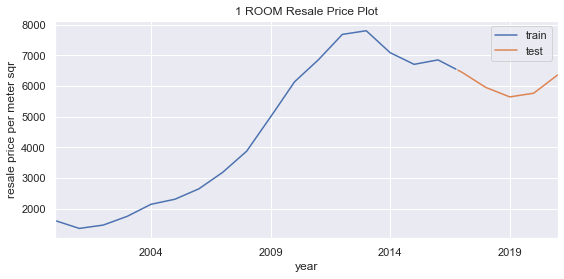

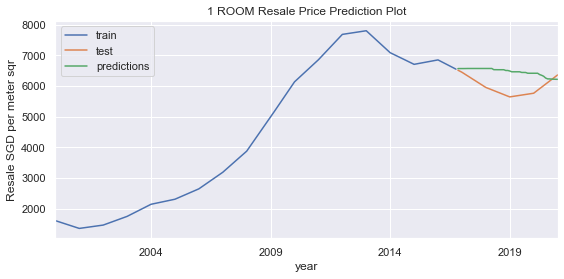

In [317]:
initForecast()


Number of models compared: 36


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:16<00:00, 25.58s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 3308826.6902203364

-------TOP 5 RESULTS-------
---------------------------
                                                 lags  \
29  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
21            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
18            [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
35  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
32  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                    params        metric  max_depth  \
29   {'max_depth': 5, 'n_estimators': 500}  3.308827e+06          5   
21  {'max_depth': 12, 'n_estimators': 100}  3.310133e+06         12   
18  {'max_depth': 10, 'n_estimators': 100}  3.310133e+06         10   
35  {'max_depth': 12, 'n_estimators': 500}  3.337775e+06       

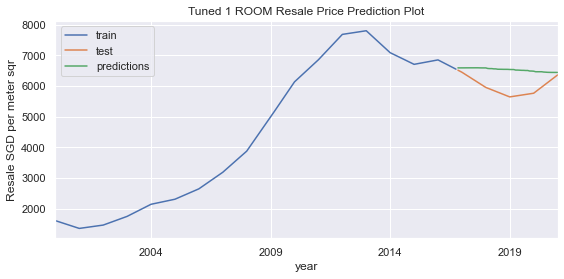

In [319]:
tunedForecaster, results_grid=tunning()


Features Selected for retrain
--------------------
Population Density (Total Population Per Square Kilometre)
Elderly_Total HDB Dwellings
Children_HDB 5-Room And Executive Flats
Non-Resident Population (Number)
Singapore Citizen Population (Number)
Children_HDB 4-Room Flats
Elderly_HDB 1 And 2 Room Flats
Resident Population (Number)
Elderly_HDB 3-Room Flats
Children_Landed Properties
Children_Total HDB Dwellings
Adult_HDB 5-Room And Executive Flats
Elderly_HDB 4-Room Flats
Adult_Total HDB Dwellings
Adult_HDB 1 And 2 Room Flats
Elderly_Condominiums & Other Apartments
Permanent Resident Population (Number)
Adult_Condominiums & Other Apartments
Elderly_Landed Properties
Total Population (Number)
Elderly_HDB 5-Room And Executive Flats
Children_HDB 1 And 2 Room Flats
Number of models compared: 36


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:18<00:00, 26.06s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 12, 'n_estimators': 100}
  Backtesting metric: 3165624.1399712875

Test error (mse): 327917.2851529413


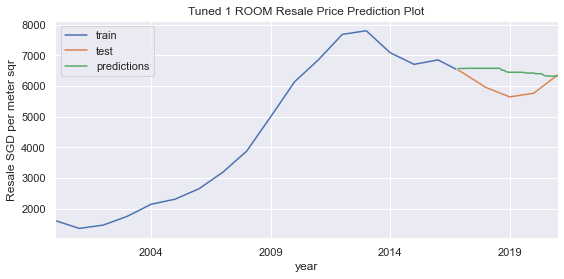

In [346]:
importantfeatures=retrain(tunedForecaster)


Train interval : 2000-01-01 00:00:00 --- 2018-11-01 00:00:00  (n=227)
Test interval  : 2018-12-01 00:00:00 --- 2021-01-01 00:00:00  (n=26)
ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=RandomState(MT19937) at 0x14B8CBEDBF8) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['Total Population (Number)', 'Resident Population (Number)', 'Singapore Citizen Population (Number)', 'Permanent Resident Population (Number)', 'Non-Resident Population (Number)', 'Total Population Growth (Per Cent)', 'Resident Population Growth (Per Cent)', 'Population Density (Total Population Per Square Kilometre)', 'Median Age Of Resident Population (Years)', 'Median Age Of Citizen Population (Years)', 'Natural Increase (Number)', 'Children_Total HDB Dwellings', 'Children_HDB 1 And 2 Room Flats', 'Children_HDB 3-Room Flats', 'Children_HDB 4-Room Flats', 'Children_HDB 5-Room And Execu

loop lags_grid: 100%|███████████████████████████████████████| 3/3 [02:16<00:00, 45.57s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 12, 'n_estimators': 100}
  Backtesting metric: 498356.93252807023

-------TOP 5 RESULTS-------
---------------------------
                                                 lags  \
33  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
31  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6                                     [1, 2, 3, 4, 5]   

                                    params         metric  max_depth  \
33  {'max_depth': 12, 'n_estimators': 100}  498356.932528         12   
30  {'max_depth': 10, 'n_estimators': 100}  498401.024006         10   
31  {'max_depth': 10, 'n_estimators': 250}  503750.022859         10   
34  {'max_depth': 12, 'n_estimators': 250}  505135.718659 

loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:59<00:00, 39.79s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 12, 'n_estimators': 250}
  Backtesting metric: 491431.18819536845

Test error (mse): 168076.36664799994


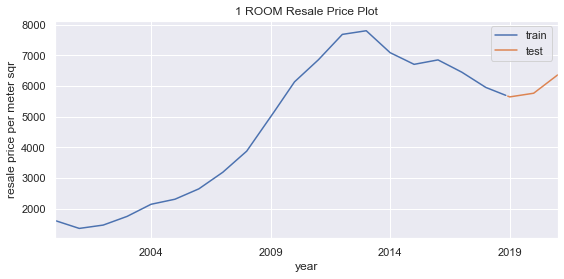

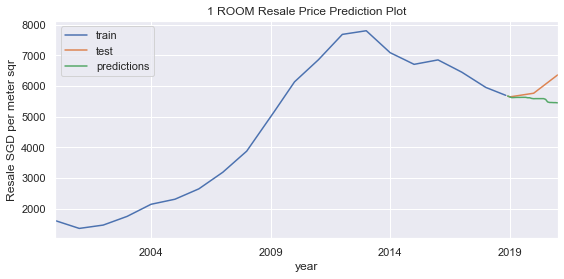

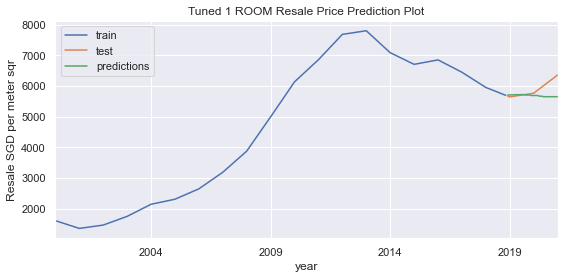

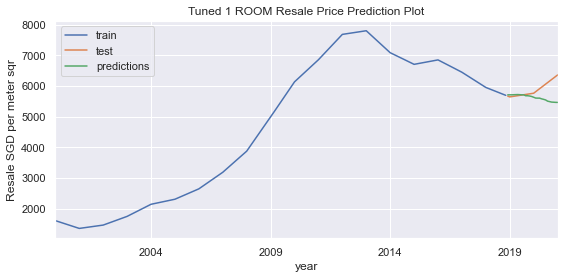

In [347]:
target = '1 ROOM'
ratio = 0.9
# train test split
x_train, x_test, y_train, y_test, steps = train_test_split(
    data, target=target, ratio=ratio)
initForecast()
tunedForecaster, results_grid = tunning()
importantfeatures = retrain(tunedForecaster)


In [351]:
## experimental train_test_split, property price of other property type will be used to predict the outcome of the target property type

def train_test_split_experiment(data, target, ratio=0.8):
    # Split data into train-test
    # Split at 2:8
    steps = int(data.shape[0]*ratio)
    data_train = data[:steps]
    data_test = data[steps:]
    steps = len(data_test)
    print(
        f"Train interval : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
    print(
        f"Test interval  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

    x_train = data_train.drop(target,axis=1)
    x_test = data_test.drop(target,axis=1)
    y_train = data_train[target]
    y_test = data_test[target]
    return x_train, x_test, y_train, y_test, steps


Train interval : 2000-01-01 00:00:00 --- 2016-10-01 00:00:00  (n=202)
Test interval  : 2016-11-01 00:00:00 --- 2021-01-01 00:00:00  (n=51)
ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=RandomState(MT19937) at 0x14B8CBEDBF8) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['2 ROOM', '3 ROOM', '4 ROOM', '5 ROOM', 'EXECUTIVE', 'MULTI-GENERATION', 'Total Population (Number)', 'Resident Population (Number)', 'Singapore Citizen Population (Number)', 'Permanent Resident Population (Number)', 'Non-Resident Population (Number)', 'Total Population Growth (Per Cent)', 'Resident Population Growth (Per Cent)', 'Population Density (Total Population Per Square Kilometre)', 'Median Age Of Resident Population (Years)', 'Median Age Of Citizen Population (Years)', 'Natural Increase (Number)', 'Children_Total HDB Dwellings', 'Children_HDB 1 And 2 Room Flats', 'Children_HDB 3

loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:19<00:00, 26.59s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 10, 'n_estimators': 250}
  Backtesting metric: 3239329.684847525

-------TOP 5 RESULTS-------
---------------------------
                                                 lags  \
31  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
34  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
33  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
30  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
28  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   

                                    params        metric  max_depth  \
31  {'max_depth': 10, 'n_estimators': 250}  3.239330e+06         10   
34  {'max_depth': 12, 'n_estimators': 250}  3.239330e+06         12   
33  {'max_depth': 12, 'n_estimators': 100}  3.255433e+06         12   
30  {'max_depth': 10, 'n_estimators': 100}  3.255433e+06       

loop lags_grid: 100%|███████████████████████████████████████| 3/3 [01:15<00:00, 25.17s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'max_depth': 10, 'n_estimators': 500}
  Backtesting metric: 3132548.6392263356

Test error (mse): 325640.4646967474


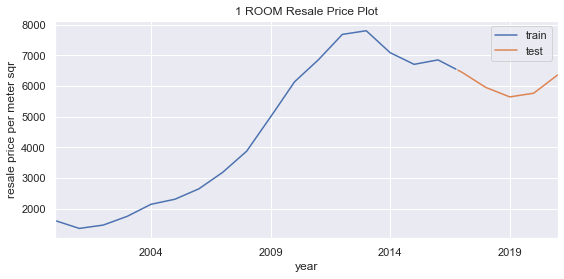

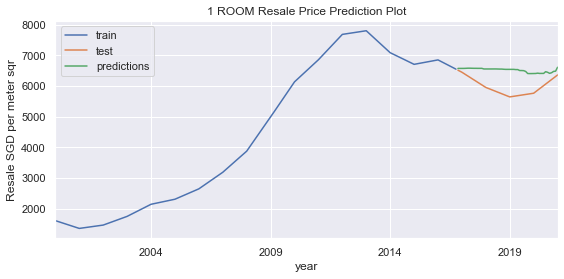

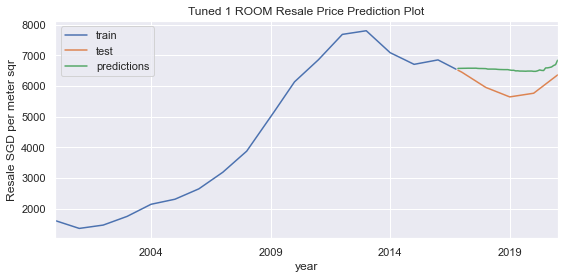

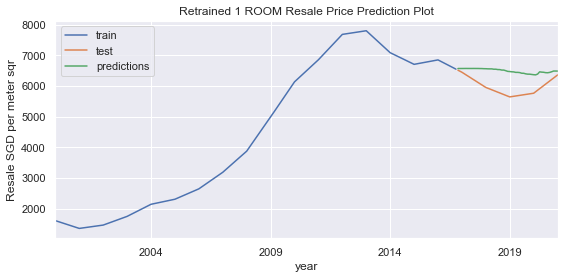

In [352]:
target = '1 ROOM'
ratio = 0.8
# train test split
x_train, x_test, y_train, y_test, steps = train_test_split_experiment(
    data, target=target, ratio=ratio)
initForecast()
tunedForecaster, results_grid = tunning()
importantfeatures = retrain(tunedForecaster)
